In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Combining CSV's into single dataframe(Label1)

## Hindi language

In [1]:
import pandas as pd
import re
from collections import Counter
import csv
from datasets import Dataset  # HuggingFace Datasets library

# ------------------------------
# 1. Define Helper Functions for CSV Reading and Majority Vote
# ------------------------------

def read_csv_auto_sep(filepath):
    """
    Read a CSV file by attempting to auto-detect the delimiter.
    Falls back to comma if detection fails.
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        sample = f.read(2048)
        try:
            dialect = csv.Sniffer().sniff(sample)
            delimiter = dialect.delimiter
        except csv.Error:
            print(f"Could not detect delimiter for {filepath}. Falling back to comma.")
            delimiter = ','
    df = pd.read_csv(filepath, sep=delimiter, encoding='utf-8', engine='python', on_bad_lines='skip')
    if len(df.columns) == 1:
        print(f"Retrying with comma separator for {filepath}...")
        df = pd.read_csv(filepath, sep=',', encoding='utf-8', engine='python', on_bad_lines='skip')
    return df

def majority_vote(row, annotator_cols):
    """
    Compute majority vote from multiple annotator columns.
    If tie or no valid votes, returns 0.
    """
    votes = [row[col] for col in annotator_cols if pd.notnull(row[col])]
    if not votes:
        return 0  # Default if no votes are available
    vote_counts = Counter(votes)
    most_common = vote_counts.most_common()
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0  # Tie case
    return most_common[0][0]

# ------------------------------
# 2. Read Hindi CSV
# ------------------------------

# Update the path to your Hindi CSV file
file_hi = "/home/shubham24165/NLP-Project/task_2/uli-data/training/train_hi_l1.csv"
df_hi = read_csv_auto_sep(file_hi)
print("Columns found in Hindi file:", df_hi.columns.tolist())

# For Hindi, we expect these annotator columns:
hi_annotator_cols = ["hi_a1", "hi_a2", "hi_a3", "hi_a4", "hi_a5"]

# Add language tag
df_hi["language"] = "hi"

# Apply majority vote to create final_label
df_hi["final_label"] = df_hi.apply(lambda row: majority_vote(row, hi_annotator_cols), axis=1)

# Keep only the needed columns (ensure column 'text' exists)
if "text" not in df_hi.columns:
    # If the file uses an alternate column name, for example 'tweet' or 'content', rename it:
    if 'tweet' in df_hi.columns:
        df_hi.rename(columns={'tweet': 'text'}, inplace=True)
    elif 'content' in df_hi.columns:
        df_hi.rename(columns={'content': 'text'}, inplace=True)
    else:
        raise ValueError("No 'text' column found in the Hindi CSV file.")

df_hi = df_hi[["text", "final_label", "language"]]
print("Hindi DataFrame preview:")
print(df_hi.head())

# ------------------------------
# 3. Hindi Preprocessing Functions
# ------------------------------

def preprocess_hindi_text(text):
    """
    Preprocess Hindi text: convert to lowercase, remove hashtags, URLs, handle placeholders,
    remove emojis, and preserve Hindi characters (Unicode range: \u0900-\u097F).
    """
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'<handle replaced>', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove emojis: a simple regex for common emoji ranges
    emoji_pattern = re.compile("[\U0001F600-\U0001F64F"
                               "\U0001F300-\U0001F5FF"
                               "\U0001F680-\U0001F6FF]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    # Preserve only Hindi Unicode characters, numerals, and whitespace
    text = re.sub(r'[^\u0900-\u097F0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply Hindi preprocessing
df_hi['clean_text'] = df_hi['text'].apply(preprocess_hindi_text)
print("\nPreview with cleaned Hindi text:")
print(df_hi[['text', 'clean_text', 'final_label', 'language']].head())

# ------------------------------
# 4. Convert to HuggingFace Dataset
# ------------------------------

# Optionally, if you prefer to work only with the cleaned text, rename 'clean_text' to 'text'
# df_hi = df_hi[['clean_text', 'final_label', 'language']].rename(columns={'clean_text': 'text'})

# # Convert the cleaned Hindi DataFrame to a HuggingFace Dataset
# hf_dataset_hi = Dataset.from_pandas(df_hi)
# print("\nHuggingFace Hindi Dataset Preview:")
# print(hf_dataset_hi[0])


Retrying with comma separator for /home/shubham24165/NLP-Project/task_2/uli-data/training/train_hi_l1.csv...
Columns found in Hindi file: ['text', 'key', 'hi_a1', 'hi_a2', 'hi_a3', 'hi_a4', 'hi_a5']
Hindi DataFrame preview:
                                                text final_label language
0    भारत में तीन किसान कानून बिल वापस लेने पर भक...         0.0       hi
1    राजस्थान  अजीबोगरीब: गांव की खुशहाली के लिए ...         0.0       hi
2    सलमान ने की राखी के विरोधी की वकालत तो 'आइटम...         0.0       hi
3  !!हर शब्द अमॄतम!!  पुरानी एक कहावत है... टूटी ...         0.0       hi
4  "PM मोदी जी " की माँ के लिए अपशब्द कहने वाला द...         1.0       hi

Preview with cleaned Hindi text:
                                                text  \
0    भारत में तीन किसान कानून बिल वापस लेने पर भक...   
1    राजस्थान  अजीबोगरीब: गांव की खुशहाली के लिए ...   
2    सलमान ने की राखी के विरोधी की वकालत तो 'आइटम...   
3  !!हर शब्द अमॄतम!!  पुरानी एक कहावत है... टूटी ...   
4  "PM मोदी जी " क

In [2]:
# Rename 'clean_text' to 'text' and then drop 'clean_text'
df_hi = df_hi.drop(columns=["text"])
df_hi = df_hi.rename(columns={"clean_text": "text"})

print(df_hi.head())

  final_label language                                               text
0         0.0       hi  भारत में तीन किसान कानून बिल वापस लेने पर भक्त...
1         0.0       hi  राजस्थान अजीबोगरीब गांव की खुशहाली के लिए रात ...
2         0.0       hi  सलमान ने की राखी के विरोधी की वकालत तो आइटम गर...
3         0.0       hi  हर शब्द अमॄतम पुरानी एक कहावत है टूटी की नही ब...
4         1.0       hi  मोदी जी की माँ के लिए अपशब्द कहने वाला दोगला भ...


In [3]:
df_hi = df_hi[['text', 'final_label', 'language']]
print(df_hi.head())
print(df_hi.tail(10))  # Prints the last 10 rows

                                                text final_label language
0  भारत में तीन किसान कानून बिल वापस लेने पर भक्त...         0.0       hi
1  राजस्थान अजीबोगरीब गांव की खुशहाली के लिए रात ...         0.0       hi
2  सलमान ने की राखी के विरोधी की वकालत तो आइटम गर...         0.0       hi
3  हर शब्द अमॄतम पुरानी एक कहावत है टूटी की नही ब...         0.0       hi
4  मोदी जी की माँ के लिए अपशब्द कहने वाला दोगला भ...         1.0       hi
                                                   text final_label language
6187  अब ुकाबला ायवाले और ूतवाले के बीच है तय ा के क...         0.0       hi
6188  बिजली को लेकर आम आदमी पार्टी का रंडी स्यापा शु...         0.0       hi
6189  राजनीति के नाम पर हिन्दू हनन का समर्थन करने वा...         0.0       hi
6190  मेने तो पेले से ई टिकटॉक डाउनलोड कल्लिया हे मू...         0.0       hi
6191  महान चारणभांट पालतू सिरमौर भांड पांच अगस्त से ...         0.0       hi
6192  काम वाली बाई का फोन आया पत्नि को। कामवाली कल स...         0.0       hi
6193  ग्रुप में च

In [4]:
# Step 1: Install required libraries (if not already installed)
!pip install datasets transformers

In [5]:
!pip install gdown
import gdown

In [ ]:
import gdown
import os

# Google Drive shareable link provided:
drive_link = "https://drive.google.com/file/d/1-ojPP71SMtC9xHdwjRH0B1yoZkvbYPyw/view?usp=sharing"

# Extract the file ID from the link.
# For this link, the file ID is "1-ojPP71SMtC9xHdwjRH0B1yoZkvbYPyw"
file_id = "1-ojPP71SMtC9xHdwjRH0B1yoZkvbYPyw"

# Construct a download URL in the required format:
download_url = f"https://drive.google.com/uc?id={file_id}"

# Set destination path in Colab's local filesystem
destination = "/content/abusexlmr_checkpoint.zip"

# Download the file
gdown.download(download_url, destination, quiet=False)

# Unzip the checkpoint
!unzip {destination} -d /content/abusexlmr_checkpoint

Downloading...
From (original): https://drive.google.com/uc?id=1-ojPP71SMtC9xHdwjRH0B1yoZkvbYPyw
From (redirected): https://drive.google.com/uc?id=1-ojPP71SMtC9xHdwjRH0B1yoZkvbYPyw&confirm=t&uuid=62a8be2a-7fb2-4b93-843e-43beb0fdf05e
To: /content/abusexlmr_checkpoint.zip
100%|██████████| 1.80G/1.80G [00:13<00:00, 134MB/s] 


Archive:  /content/abusexlmr_checkpoint.zip
replace /content/abusexlmr_checkpoint/__MACOSX/._abusexlmr? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: /content/abusexlmr_checkpoint/__MACOSX/._abusexlmr  
replace /content/abusexlmr_checkpoint/abusexlmr/rng_state.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: /content/abusexlmr_checkpoint/abusexlmr/rng_state.pth  
replace /content/abusexlmr_checkpoint/__MACOSX/abusexlmr/._rng_state.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: /content/abusexlmr_checkpoint/__MACOSX/abusexlmr/._rng_state.pth  
replace /content/abusexlmr_checkpoint/abusexlmr/tokenizer_config.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: /content/abusexlmr_checkpoint/abusexlmr/tokenizer_config.json  
replace /content/abusexlmr_checkpoint/__MACOSX/abusexlmr/._tokenizer_config.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: /content/abusexlmr_checkpoint/__MACOSX/abusexlmr/._tokenizer_config.json  
replace /content

## Tokenization using AbuseXLMR tokenizer
(git link: https://github.com/ShareChatAI/MACD)

In [6]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

# Assume your cleaned DataFrame is called train_df
print(df_hi.head())

# Ensure final_label is numeric
df_hi['final_label'] = pd.to_numeric(df_hi['final_label'], errors='coerce')

# Convert DataFrame to HuggingFace Dataset
hf_dataset = Dataset.from_pandas(df_hi)

# For simplicity, perform a train/validation split (e.g., 80/20 split)
dataset_split = hf_dataset.train_test_split(test_size=0.2, seed=42)
dataset_dict = DatasetDict({
    "train": dataset_split["train"],
    "validation": dataset_split["test"]
})

# Optional: Inspect the split
print("Train dataset size:", dataset_dict["train"].num_rows)
print("Validation dataset size:", dataset_dict["validation"].num_rows)

# --- Use AbuseXLMR tokenizer ---
model_name = "/home/shubham24165/NLP-Project/task_2/abusexlmr_checkpoint/abusexlmr"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    # We use the cleaned 'text' field; adjust max_length as needed
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# Apply tokenization to the dataset (batched for efficiency)
tokenized_dataset = dataset_dict.map(tokenize_function, batched=True)

# Inspect a sample from the tokenized dataset
print(tokenized_dataset["train"][1000])


                                                text final_label language
0  भारत में तीन किसान कानून बिल वापस लेने पर भक्त...         0.0       hi
1  राजस्थान अजीबोगरीब गांव की खुशहाली के लिए रात ...         0.0       hi
2  सलमान ने की राखी के विरोधी की वकालत तो आइटम गर...         0.0       hi
3  हर शब्द अमॄतम पुरानी एक कहावत है टूटी की नही ब...         0.0       hi
4  मोदी जी की माँ के लिए अपशब्द कहने वाला दोगला भ...         1.0       hi
Train dataset size: 4957
Validation dataset size: 1240


Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

Map:   0%|          | 0/1240 [00:00<?, ? examples/s]

{'text': 'जन्म से लेकर मृत्यु तक के सभी विशेष अवसरों पर इन पाँच लोगों की उपस्थिति और सम्मान हो तभी वह सम्पन्न होती है ब्राह्मणनाईधोबीचमारकहार। मतलब हर हाथ काम और सबकी सबपर निर्भरता।इसे पुनः प्रतिष्ठित करना होगा।', 'final_label': 0.0, 'language': 'hi', 'input_ids': [0, 22274, 646, 19697, 17099, 7231, 287, 17415, 16061, 54044, 1302, 968, 10423, 36307, 15728, 471, 171500, 871, 54577, 1253, 168626, 11692, 30402, 11091, 460, 157517, 998, 9729, 83612, 36548, 411, 104854, 41376, 125, 144692, 10619, 54985, 3313, 871, 15699, 5011, 15699, 16585, 32157, 20785, 1480, 125, 69006, 976, 56939, 9974, 59068, 3282, 16835, 16492, 125, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [7]:
tokenized_dataset = tokenized_dataset.rename_column("final_label", "labels")

## Finetuning AbuseXLMR(Multi-lingual Representation of Indic Languages)

In [8]:
import os

# Set your custom project name here
os.environ["WANDB_PROJECT"] = "GenderedAbuse_Detection"

In [9]:
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer
from sklearn.metrics import precision_recall_fscore_support
from datasets import DatasetDict
from datasets import Value

# Ensure labels are ints
def cast_to_int(example):
    example['labels'] = int(example['labels']) if example['labels'] is not None else 0
    return example

tokenized_dataset = tokenized_dataset.map(cast_to_int)
tokenized_dataset = tokenized_dataset.cast_column("labels", Value("int64"))

# ---- STEP 2: Define compute_metrics ----
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    return {
        "precision": precision,
        "recall": recall,
        "macro_f1": f1
    }

# ---- STEP 3: Load MuRIL model and tokenizer ----
model_name = "/home/shubham24165/NLP-Project/task_2/abusexlmr_checkpoint/abusexlmr"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# ---- STEP 4: Define training arguments ----
training_args = TrainingArguments(
    output_dir="/home/shubham24165/NLP-Project/task_2/AbuseXLMR_gendered_abuse_hindi",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,                          # keep the best
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    report_to="wandb",                           #Logs to wandb
    run_name="abusexlmr_hindi",                 
)



# ---- STEP 5: Trainer setup ----
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics
)

# ---- STEP 6: Start training ----
trainer.train()

# ---- STEP 7: Evaluate ----
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

Map:   0%|          | 0/1240 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/4957 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1240 [00:00<?, ? examples/s]

/home/shubham24165/.conda/envs/deeplearning/lib/python3.9/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the f

Epoch,Training Loss,Validation Loss,Precision,Recall,Macro F1
1,No log,0.492107,0.735593,0.671823,0.688677
2,0.557100,0.490551,0.742203,0.677266,0.694755
3,0.557100,0.539599,0.715857,0.689130,0.699225
4,0.409500,0.671850,0.712107,0.650292,0.664821
5,0.306400,0.850532,0.694967,0.691468,0.693145
6,0.306400,0.984931,0.689946,0.670085,0.677785
7,0.219700,1.082019,0.689359,0.679538,0.683874
8,0.219700,1.221125,0.682589,0.666166,0.672735
9,0.186600,1.251158,0.685477,0.666084,0.673573
10,0.161100,1.254735,0.687352,0.664560,0.672996


Evaluation Results: {'eval_loss': 0.5395992994308472, 'eval_precision': 0.7158568566208969, 'eval_recall': 0.6891303155183932, 'eval_macro_f1': 0.6992249204821384, 'eval_runtime': 2.9828, 'eval_samples_per_second': 415.723, 'eval_steps_per_second': 26.15, 'epoch': 10.0}


## Evaluation

In [11]:
import pandas as pd
import re
from collections import Counter
import csv
from datasets import Dataset  # HuggingFace Datasets library

# ------------------------------
# 1. Read the Hindi CSV File
# ------------------------------

def read_csv_auto_sep(filepath):
    """
    Read a CSV file by attempting to auto-detect the delimiter.
    Falls back to comma if detection fails, and retries with comma if only one column is found.
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        sample = f.read(2048)
        try:
            dialect = csv.Sniffer().sniff(sample)
            delimiter = dialect.delimiter
        except csv.Error:
            print(f"Could not detect delimiter for {filepath}. Falling back to comma.")
            delimiter = ','
    df = pd.read_csv(filepath, sep=delimiter, encoding='utf-8', engine='python', on_bad_lines='skip')
    if len(df.columns) == 1:
        print(f"Retrying with comma separator for {filepath}...")
        df = pd.read_csv(filepath, sep=',', encoding='utf-8', engine='python', on_bad_lines='skip')
    return df

# Specify the path to your Hindi CSV file
file_hi = "/home/shubham24165/NLP-Project/task_2/uli-data/training/train_hi_l1.csv"
df_hi = read_csv_auto_sep(file_hi)
print("Columns found in Hindi file:", df_hi.columns.tolist())

# ------------------------------
# 2. Apply Majority Vote for Hindi
# ------------------------------

def majority_vote(row, annotator_cols):
    """
    Compute majority vote from multiple annotator columns.
    Returns 0 in case of a tie or if no valid votes are present.
    """
    votes = [row[col] for col in annotator_cols if pd.notnull(row[col])]
    if not votes:
        return 0
    vote_counts = Counter(votes)
    most_common = vote_counts.most_common()
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0
    return most_common[0][0]

# For Hindi, we expect these annotator columns:
hi_annotator_cols = ["hi_a1", "hi_a2", "hi_a3", "hi_a4", "hi_a5"]

# If the 'text' column doesn't exist, check for common alternatives:
if 'text' not in df_hi.columns:
    if 'tweet' in df_hi.columns:
        df_hi.rename(columns={'tweet': 'text'}, inplace=True)
    elif 'content' in df_hi.columns:
        df_hi.rename(columns={'content': 'text'}, inplace=True)
    else:
        raise ValueError("No 'text' column found in the Hindi CSV file.")

# Tag language as 'hi'
df_hi["language"] = "hi"

# Apply majority vote to create final_label
df_hi["final_label"] = df_hi.apply(lambda row: majority_vote(row, hi_annotator_cols), axis=1)

# Keep only needed columns
df_hi = df_hi[["text", "final_label", "language"]]
print("Hindi DataFrame preview:")
print(df_hi.head())

# ------------------------------
# 3. Preprocess Hindi Text Only
# ------------------------------

def preprocess_hindi_text(text):
    """
    Preprocess Hindi text by lowercasing, removing hashtags, handles, URLs, emojis,
    and preserving only Hindi Unicode characters (range \u0900-\u097F), numerals, and whitespace.
    """
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'<handle replaced>', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    emoji_pattern = re.compile("[\U0001F600-\U0001F64F"
                               "\U0001F300-\U0001F5FF"
                               "\U0001F680-\U0001F6FF]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    text = re.sub(r'[^\u0900-\u097F0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply Hindi preprocessing to create a new 'clean_text' column
df_hi['clean_text'] = df_hi['text'].apply(preprocess_hindi_text)
print("\nPreview with cleaned Hindi text:")
print(df_hi[['text', 'clean_text', 'final_label', 'language']].head())

# ------------------------------
# 4. Convert to HuggingFace Dataset
# ------------------------------

# # If you want to work only with cleaned text, rename 'clean_text' to 'text'
test_df = df_hi[['clean_text', 'final_label', 'language']].rename(columns={'clean_text': 'text'})

# # Convert the final DataFrame to a HuggingFace Dataset
# hf_dataset_hi = Dataset.from_pandas(df_hi)

# print("\nHuggingFace Hindi Dataset Preview:")
# print(hf_dataset_hi[0])


Retrying with comma separator for /home/shubham24165/NLP-Project/task_2/uli-data/training/train_hi_l1.csv...
Columns found in Hindi file: ['text', 'key', 'hi_a1', 'hi_a2', 'hi_a3', 'hi_a4', 'hi_a5']
Hindi DataFrame preview:
                                                text final_label language
0    भारत में तीन किसान कानून बिल वापस लेने पर भक...         0.0       hi
1    राजस्थान  अजीबोगरीब: गांव की खुशहाली के लिए ...         0.0       hi
2    सलमान ने की राखी के विरोधी की वकालत तो 'आइटम...         0.0       hi
3  !!हर शब्द अमॄतम!!  पुरानी एक कहावत है... टूटी ...         0.0       hi
4  "PM मोदी जी " की माँ के लिए अपशब्द कहने वाला द...         1.0       hi

Preview with cleaned Hindi text:
                                                text  \
0    भारत में तीन किसान कानून बिल वापस लेने पर भक...   
1    राजस्थान  अजीबोगरीब: गांव की खुशहाली के लिए ...   
2    सलमान ने की राखी के विरोधी की वकालत तो 'आइटम...   
3  !!हर शब्द अमॄतम!!  पुरानी एक कहावत है... टूटी ...   
4  "PM मोदी जी " क

In [12]:
# Rename 'clean_text' to 'text' and then drop 'clean_text'
test_df = test_df.rename(columns={"clean_text": "text"})

print(test_df.head())

                                                text final_label language
0  भारत में तीन किसान कानून बिल वापस लेने पर भक्त...         0.0       hi
1  राजस्थान अजीबोगरीब गांव की खुशहाली के लिए रात ...         0.0       hi
2  सलमान ने की राखी के विरोधी की वकालत तो आइटम गर...         0.0       hi
3  हर शब्द अमॄतम पुरानी एक कहावत है टूटी की नही ब...         0.0       hi
4  मोदी जी की माँ के लिए अपशब्द कहने वाला दोगला भ...         1.0       hi


In [14]:
print("Columns found:", test_df.columns.tolist())
test_df = test_df[['text', 'final_label', 'language']]
print(test_df.head())
print(test_df.tail(10))  # Prints the last 10 rows

Columns found: ['text', 'final_label', 'language']
                                                text final_label language
0  भारत में तीन किसान कानून बिल वापस लेने पर भक्त...         0.0       hi
1  राजस्थान अजीबोगरीब गांव की खुशहाली के लिए रात ...         0.0       hi
2  सलमान ने की राखी के विरोधी की वकालत तो आइटम गर...         0.0       hi
3  हर शब्द अमॄतम पुरानी एक कहावत है टूटी की नही ब...         0.0       hi
4  मोदी जी की माँ के लिए अपशब्द कहने वाला दोगला भ...         1.0       hi
                                                   text final_label language
6187  अब ुकाबला ायवाले और ूतवाले के बीच है तय ा के क...         0.0       hi
6188  बिजली को लेकर आम आदमी पार्टी का रंडी स्यापा शु...         0.0       hi
6189  राजनीति के नाम पर हिन्दू हनन का समर्थन करने वा...         0.0       hi
6190  मेने तो पेले से ई टिकटॉक डाउनलोड कल्लिया हे मू...         0.0       hi
6191  महान चारणभांट पालतू सिरमौर भांड पांच अगस्त से ...         0.0       hi
6192  काम वाली बाई का फोन आया पत्नि को। काम

In [15]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer

# Assume your cleaned test DataFrame is called test_df
print("Test DF preview:")
print(test_df.head())

# Ensure 'final_label' is numeric
test_df['final_label'] = pd.to_numeric(test_df['final_label'], errors='coerce')

# Convert test_df to Hugging Face Dataset
hf_test_dataset = Dataset.from_pandas(test_df)

# Load tokenizer from AbuseXLMR model
model_name = "/home/shubham24165/NLP-Project/task_2/abusexlmr_checkpoint/abusexlmr"  # Update path if needed
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

# Apply tokenization to the test dataset (batched for efficiency)
tokenized_test_dataset = hf_test_dataset.map(tokenize_function, batched=True)

# Inspect a sample from the tokenized dataset
print("Sample tokenized test record:")
print(tokenized_test_dataset[0])  # You can change index as needed


Test DF preview:
                                                text final_label language
0  भारत में तीन किसान कानून बिल वापस लेने पर भक्त...         0.0       hi
1  राजस्थान अजीबोगरीब गांव की खुशहाली के लिए रात ...         0.0       hi
2  सलमान ने की राखी के विरोधी की वकालत तो आइटम गर...         0.0       hi
3  हर शब्द अमॄतम पुरानी एक कहावत है टूटी की नही ब...         0.0       hi
4  मोदी जी की माँ के लिए अपशब्द कहने वाला दोगला भ...         1.0       hi


Map:   0%|          | 0/6197 [00:00<?, ? examples/s]

Sample tokenized test record:
{'text': 'भारत में तीन किसान कानून बिल वापस लेने पर भक्तों की जो हालत हुई अब यह किसी से छुपा नहीं है उसके इलावा जो टट्टी खोर पत्रकार थे उनकी भी हालत खराब हुई है किसी को मुंह दिखाने के लायक नहीं है अब यह लोग यहां तक कि अपने घर में भी मुंह दिखाने के लायक नहीं रहे।', 'final_label': 0.0, 'language': 'hi', 'input_ids': [0, 3946, 421, 9443, 80811, 57384, 103716, 97186, 72268, 968, 104257, 1302, 471, 4993, 152841, 17035, 4849, 4239, 12820, 646, 28785, 8991, 2191, 460, 30237, 6, 170349, 81534, 4993, 19315, 86644, 6, 227807, 30465, 11526, 35056, 1780, 152841, 118962, 17035, 460, 12820, 629, 202668, 71760, 1187, 287, 6, 78346, 1223, 2191, 460, 4849, 4239, 19181, 31190, 7231, 1682, 5564, 5988, 421, 1780, 202668, 71760, 1187, 287, 6, 78346, 1223, 2191, 6558, 125, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1,

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Unique labels in test dataset: [0 1]

📊 Evaluation on Test Set:
 Precision (macro): 0.8552
 Recall    (macro): 0.8080
 F1 Score  (macro): 0.8266


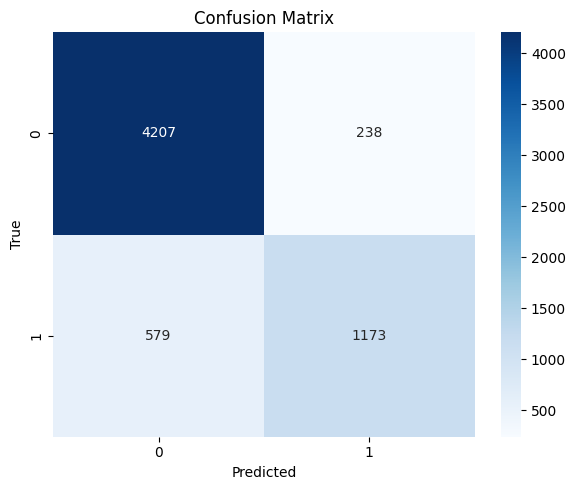

✅ Predictions on test_df saved to: /home/shubham24165/NLP-Project/task_2/predictionsAbuseXLMR_test_hindi.csv


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForSequenceClassification, Trainer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import torch

# Step 1: Load trained model from checkpoint
model_checkpoint_path = "/home/shubham24165/NLP-Project/task_2/AbuseXLMR_gendered_abuse_hindi/checkpoint-930"
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_path)

# Step 2: Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Step 3: Setup Trainer (reinitialize with new model)
trainer = Trainer(model=model)

# Step 4: Run predictions on test set
predictions_output = trainer.predict(tokenized_test_dataset)

# Step 5: Extract logits, predicted labels, and true labels
logits = predictions_output.predictions
preds = np.argmax(logits, axis=1)

# Force ground truth labels to be integers. Replace None with default value 0.
labels = np.array([int(x) if x is not None else 0 for x in tokenized_test_dataset['final_label']])

print("Unique labels in test dataset:", np.unique(labels))

# Step 6: Compute macro-averaged metrics
precision = precision_score(labels, preds, average='macro')
recall = recall_score(labels, preds, average='macro')
f1 = f1_score(labels, preds, average='macro')

print(f"\n📊 Evaluation on Test Set:")
print(f" Precision (macro): {precision:.4f}")
print(f" Recall    (macro): {recall:.4f}")
print(f" F1 Score  (macro): {f1:.4f}")

# Step 7: Plot confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Step 8: Collect original input texts from test_df (ensure test_df is properly defined)
input_texts = test_df["text"].tolist()

# Step 9: Save predictions to CSV
df = pd.DataFrame({
    "text": input_texts,
    "true_label": labels,
    "predicted_label": preds
})
csv_path = "/home/shubham24165/NLP-Project/task_2/predictionsAbuseXLMR_test_hindi.csv"
df.to_csv(csv_path, index=False)
print(f"✅ Predictions on test_df saved to: {csv_path}")